In [1]:
# We will be using numpy to generate example IQ sames for decoding, as well as generating out own IQ
# samples for encoding and transmitting
import numpy as np

# We'll use scipy for it's FFT to see how much our Gaussian pulse shaping helps
import scipy.fft
import scipy.signal.windows

# We'll use plotly for all our graphing needs
import plotly.express as px
import plotly.io as pio

# I will use this flag to export static images so that github can natively display them
pio.renderers.default = "png"
pio.kaleido.scope.default_width = 1200
pio.kaleido.scope.default_height = 400

In [2]:
# We'll start by generating an FSK signal, we'll come to the G (gaussian pulse shaping)
# part of it later.

# First I need some data to modulate. I'll just pick some arbitrary bytes that will
# demontrate transitions well
starting_data = [27, 57, 18, 48] # [0x1b, 0x39, 0x12, 0x30]
data = np.array(starting_data, dtype=np.uint8)

# let's now split up our data into our symbol size. You never mention what form of FSK
# you need. We could transmit 1 bit at a time, or 2 bits at a time, or 4, or really any
# number of bits. I will use 2 bits per symbol, since the process will generalize well
# to any number of bits at a time. This is called 4-FSK because there are 4 possible
# symbols.

# unpack the data into bits
bits = np.unpackbits(data)
print(f"{bits=}")

# re-pack the data two bits at a time to achieve our desired bits per symbol
symbols = (bits[::2] << 1) + bits[1::2]
print(f"{symbols=}")

bits=array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=uint8)
symbols=array([0, 1, 2, 3, 0, 3, 2, 1, 0, 1, 0, 2, 0, 3, 0, 0], dtype=uint8)


In [3]:
# Now I need to choose how many samples per symbol I want. This is
# directly proportional to the time spent transmitting each symbol. This also means
# that our sample rate needs to be known now. Most SDRs can achieve 2 Msps, so I will
# choose that.
sample_rate = 2e6

# lets choose 1 millisecond per symbol, and calculate how many samples that is.
samples_per_symbol = sample_rate * 1e-3
print(f"{samples_per_symbol=}")

samples_per_symbol=2000.0


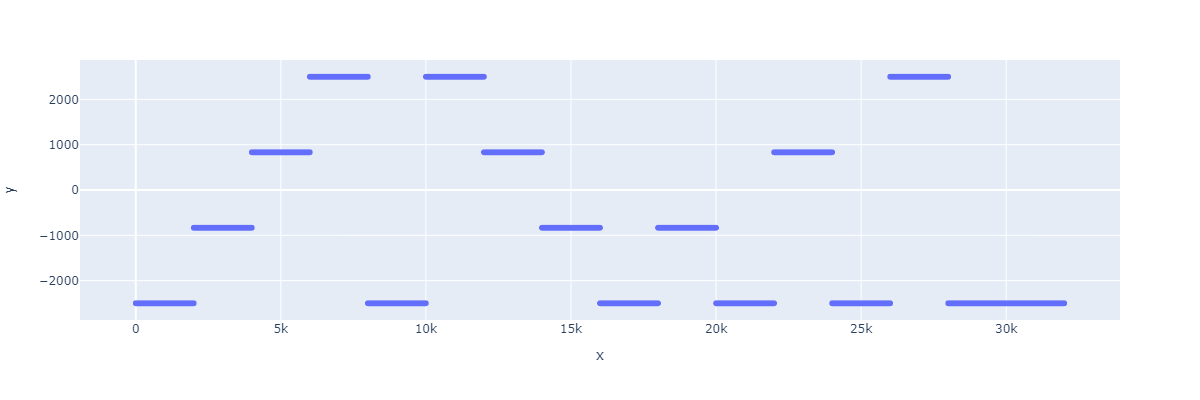

In [4]:
# Now it's time to modulate our signal into RF. For 4-FSK, we need 4 frequencies spaced
# evenly, two above and two below the carrier. You can do this with a for loop, but it
# is MUCH faster to get clever with matrix math and linear algebra with numpy.
# At this time we need to know our signal bandwidth. Lets choose 5kHz as an arbitrary
# but reasonable, if not slightly larger than needed value.

# First normalize our symbols from zero to one, then we center it around zero. Then
# we multiply our normalized, shifted frequencies by our bandwidth. This results in
# a max distance from our minimum frequency to maximum frequency of 5 kHz. We have
# negative frequencies, but that's ok! In the world of RF negative frequencies not
# only exist, but are incredibly useful.
bandwidth = 5e3
freqs = ((symbols / 3) - 0.5).repeat(samples_per_symbol) * bandwidth
px.scatter(
    x=np.linspace(0, len(freqs), len(freqs)),
    y=freqs
)

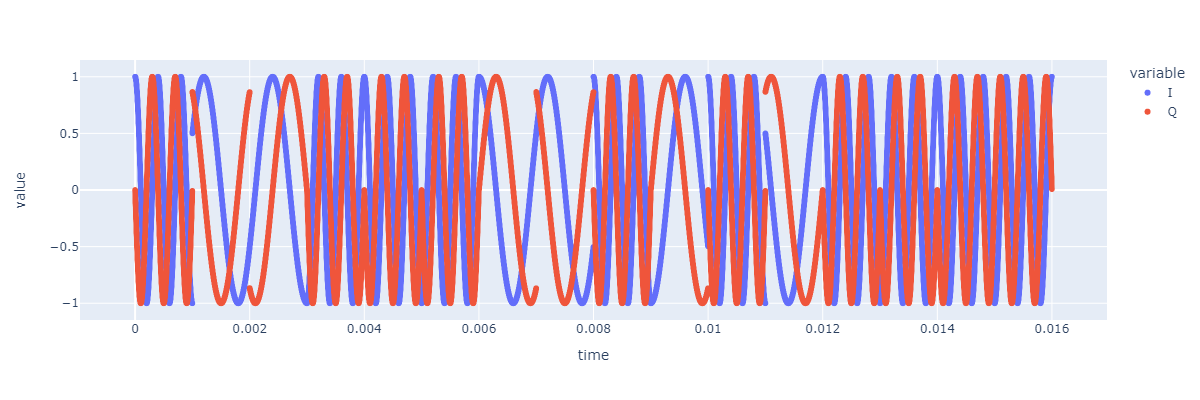

In [5]:
# we will need a time vector to generate our signal. It should go from zero to the end
# of our packet. We will cut off the last number since we want it to be the same length
# as our frequencies array
time = np.arange(0, len(freqs) / sample_rate, 1 / sample_rate)[:-1]

# Now we can generate our carrier wave. We will use euler's identity to create a
# complex carrier wave that represents our I and our Q signals at our needed frequencies.
fsk_waveform = np.exp(1j * 2 * np.pi * freqs * time)

# Now let's see what it looks like!
px.scatter(
    {
        "time": time,
        "I": fsk_waveform.real,
        "Q": fsk_waveform.imag,
    },
    x="time",
    y=["I", "Q"],
)
# Looking at the plot below, we can clearly see two different frequencies being used
# to modulate our data. But didn't we need four?
# Yes! We have negative frequencies in here! Notice how in some parts, the I signal
# (blue) is leading the Q signal (red). These represent positive frequencies. When
# the Q leads the I, we have imaginary frequencies! This gives us our four different
# frequencies

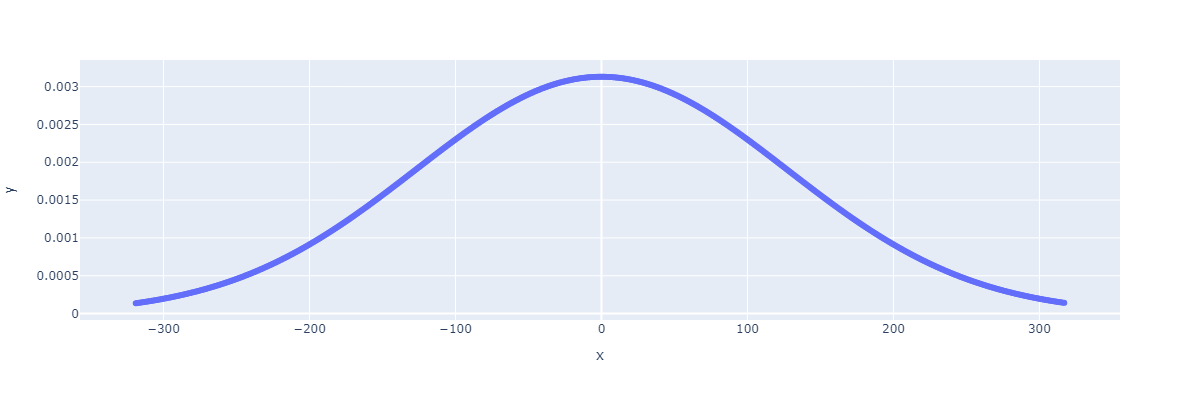

In [6]:
# Finally, in order to turn our FSK signal into GFSK, we need to run our modulated waveform
# through a Gaussian filter, in order to smooth out our transitions between frequencies. We
# smooth them out in order to prevent spectral leakage, or in other words to prevent unwanted
# frequencies from polluting our RF spectrum.

# Filtering is overall pretty straight forward. First, we generate a filtering "kernel" that
# can be reused as much as we want. To calculate our filtering kernel, we first need to determine
# our cutoff frequency, which we choose to be a little higher than our highest frequency, to
# make sure that we don't attenuate our desired signal too much. Then we need to calculate the
# standard deviation of our signal (more info here: https://en.wikipedia.org/wiki/Gaussian_filter).
# Then we choose a number of taps on our filter so that we get the majority of the gaussian
# distribution.
cutoff_frequency = 3e3
stdev = sample_rate / (cutoff_frequency * 2 * np.pi * np.sqrt(np.log(2)))
n_taps = 5 * stdev

# first make an array of x values to be used in the gaussian equation:
taps = np.arange(-n_taps // 2, n_taps // 2)

# Then use those numbers in the gaussian equation to generate an array of y values
filter = np.exp(-np.power(taps, 2) / (2 * stdev**2)) / (np.sqrt(2 * np.pi) * stdev)

# let's see what it looks like!
px.scatter(
    x=taps,
    y=np.abs(filter),
)

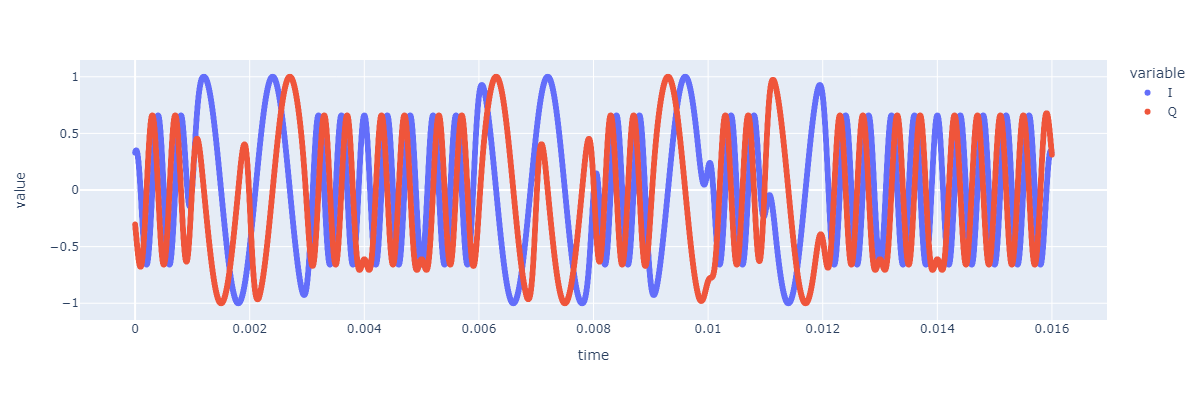

In [7]:
# Now we will apply this filter to our FSK waveform to make GFSK! We will use convolution,
# which is a very important, but sort of hard to understand concept. I would recommend
# reading up on it from other sources.
gfsk_waveform = np.convolve(fsk_waveform, filter, "same")

# Now let's normalize our waveform so that it
gfsk_waveform[:] = gfsk_waveform / np.max(gfsk_waveform)

px.scatter(
    {
        "time": time,
        "I": gfsk_waveform.real,
        "Q": gfsk_waveform.imag,
    },
    x="time",
    y=["I", "Q"],
)

# See how the filter smoothed out the transitions between different frequencies? This
# "Pulse Shaping" as it's called helps out signal come out of our transmitter more cleanly!
# There are other ways that we can clean up our signal more as well, but this is fine for now.

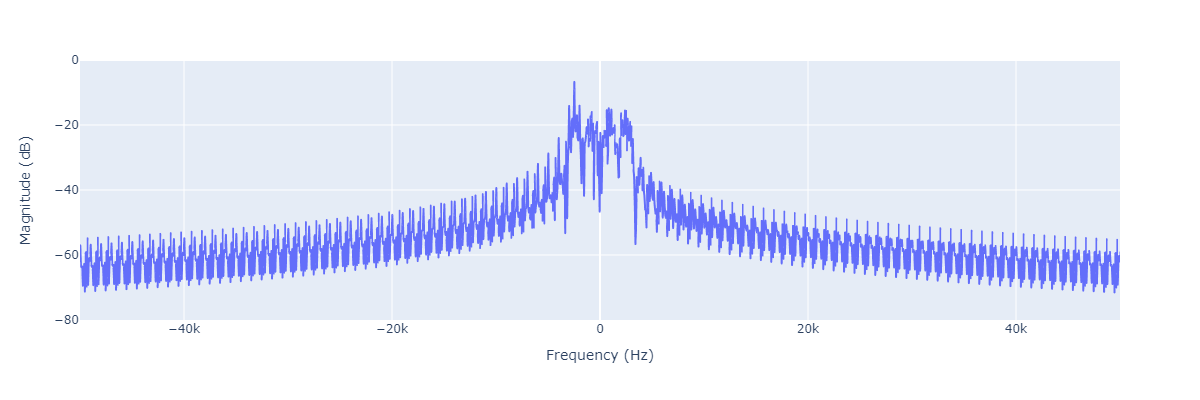

In [8]:
# But how can we quantify how well this pulse shaping filter worked? Let's check the
# FFT! We will compute the FFT in Decibels to our modulated signal before and after
# applying the filter.
fft_before = 20 * np.log10(
    scipy.fft.fftshift(
        np.abs(
            scipy.fft.fft(fsk_waveform)
        ) / len(fsk_waveform)
    )
)

_center = len(fft_before) // 2
px.line(
    {
        "Frequency (Hz)": np.linspace(-sample_rate / 2, sample_rate / 2, len(fft_before)),
        "Magnitude (dB)": fft_before
    },
    x="Frequency (Hz)",
    y="Magnitude (dB)",
    range_x=[-50e3, 50e3],
    range_y=[-80, 0]
)

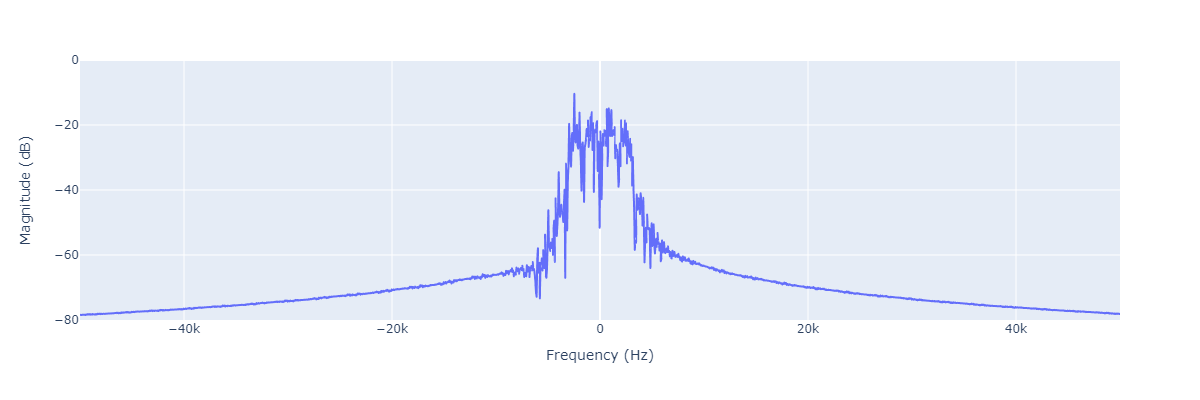

In [9]:
# Now  take the FFT of our signal after applying the filter
fft_after = 20 * np.log10(
    scipy.fft.fftshift(
        np.abs(
            scipy.fft.fft(gfsk_waveform)
        ) / len(gfsk_waveform)
    )
)

_center = len(fft_after) // 2
px.line(
    {
        "Frequency (Hz)": np.linspace(-sample_rate / 2, sample_rate / 2, len(fft_before)),
        "Magnitude (dB)": fft_after
    },
    x="Frequency (Hz)",
    y="Magnitude (dB)",
    range_x=[-50e3, 50e3],
    range_y=[-80, 0]
)
# We managed to reduce out of band emissions significantly! by almost 20 dB in this case!
# This helps our transmitter be more efficient and interfere less with neighboring signals.

In [10]:
# Now our `waveform` array is completely ready to be transmitted! Send it off into SoapySDR
# and enjoy the fruits of your labor! The SDR will handle taking our low frequency
# (-2.5 kHz to 2.5 kHz) up to radio frequencies. I won't show that here, I'll make a different
# tutorial for that later. Plus, a Jupyter notebook isn't the best format to do such things in.

In [11]:
# Now to decode our signal that we just made! There are two important stages for decoding
# that I'm going to gloss over here though. Entire thesis papers can be and have been
# written on this subject matter, so it's a little deep for an introduction:
# Packet detecting and synchronization. It suffices me to say right now that these things
# can be done with something as simple as power detection and correlation stages in the
# decoder, for now we'll move onto the FSK specifics.
#
# Why not GFSK specifics? Because on the demodulator side, there is no difference between
# FSK and GFSK! They are demodulated exactly the same.

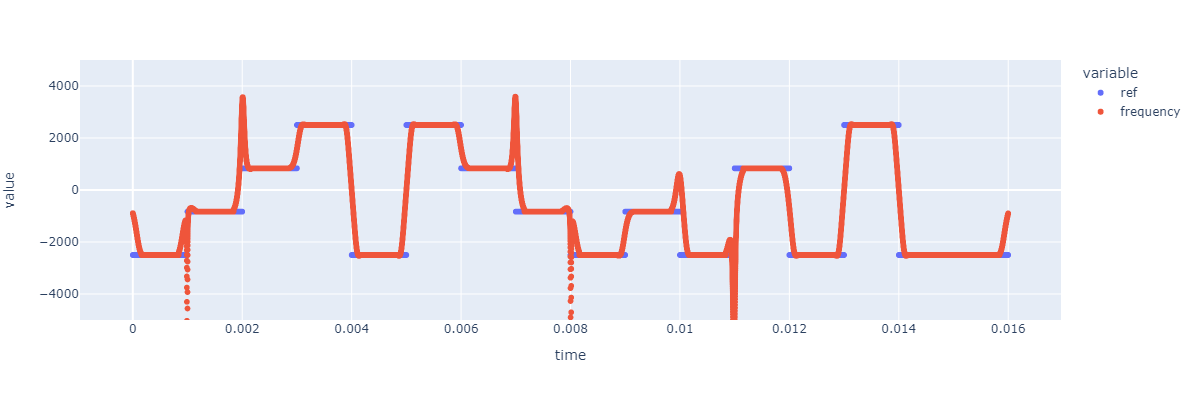

In [16]:
# There are a ton of ways that we can demodulate the waveform. Most have pros and cons,
# and this one is no exception. It's probably more computationally expensive than
# optimal, but it's pretty simple to understand and implement
angles = np.unwrap(np.angle(gfsk_waveform))
demod_d_angles = np.empty(gfsk_waveform.shape)
demod_d_angles[1:] = np.diff(angles)
demod_d_angles[0] = angles[0]

demod_frequencies = demod_d_angles * sample_rate / (2 * np.pi)

# Now let's pick a symbol and see what it looks like after this stage of demodulating
target_symbol = 0
px.scatter(
    {
        "time": time,
        "frequency": demod_frequencies,
        "ref": freqs
    },
    x="time",
    y=["ref", "frequency"],
    range_y=[-bandwidth, bandwidth]
).show()
# We can see that we get back a pretty close match for the frequencies that we put into
# the modulator. We can decode these frequencies back into our symbols

In [13]:
# Now we just need to compute what we see in the plot above. We need to average a number
# of samples equal to the length of each symbol.

# Averaging is done by reshaping our array so that the indexing is as follows:
# demod[symbol_carrier_indices, symbol_indices, samples]
# We do the reshaping because it allows us to easily sum up all of the entries in the
# third index. Then, by dividing by the number of samples, we get an average value.

# reshape our array to allow for easy averaging
reshaped_demod = demod_frequencies.reshape(
    (len(demod_frequencies) // int(samples_per_symbol), int(samples_per_symbol))
)

# sum and divide to get our average
averaged_demod = np.sum(reshaped_demod, axis=1) / samples_per_symbol

# remap our averaged frequencies to our symbols. In this case, it's easy because our
# symbols are sequential. After mapping, we round.
demod_symbols = np.round(np.interp(averaged_demod, (-bandwidth / 2, bandwidth / 2), (0, 3))).astype(np.uint8)
print(demod_symbols)

[0 1 2 3 0 3 2 1 0 1 0 2 0 3 0 0]


In [14]:
# Now we just repack our symbols into whole bytes!
demod_data = (
    (demod_symbols[0::4] << 6)
    + (demod_symbols[1::4] << 4)
    + (demod_symbols[2::4] << 2)
    + (demod_symbols[3::4])
)
demod_data

array([27, 57, 18, 48], dtype=uint8)

In [15]:
# We have reconstructed our GFSK data into the same bytes that we modulated earlier!
# Do note that, again, there are many ways to both modulate and demodulate the same signal.
# This method is likely neither the easiest, nor the most optimized, but it is valid.
# 
# Also note that I am missing the very important demodulation stages of packet detecting
# and synchronization, but those are beasts all their own, and I have not solidified my
# own knowledge in performing them from scratch, so I'll leave them to your own research.